In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [3]:
#Reading the four csv files in the MovieLens Downloaded data
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_cols,encoding='latin-1')

rating_cols = ['user_id', 'movie_id','rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_cols,encoding='latin-1')

movies_cols = ['movie_id','movie_title', 'release_date', 'video_release_date','IMDb_URL', 'unknown', 'Action', 
               'Adventure','Animation','Children', 'Comedy' , 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film_Noir',  'Horror',  'Musical', 'Mystery', 'Romance', 'Sci-Fi','Thriller','War','Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols,encoding='latin-1')

In [7]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [9]:
print(movies.shape)
movies.head()

(1682, 24)


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
##We assign a unique number between (0, #users) to each user and do the same for movies.
ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.movie_id = ratings.movie_id.astype('category').cat.codes.values

In [13]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2)

## Matrix Factorization for Keras

The key thing is to learn an embedding for movies and users, and then combine them using the dot product! For estimating the rating, for each user, movie pair of interest, we'd take the dot product of the respective user and item embedding. As an example, if we have 2 dimensions in our user and item embedding, which say correspond to [how much user likes action, how much user likes long movies], and the item embedding is [how much action is in the movie, how long is the movie]. Then, we can predict for a user u, and movie m as how much u likes action ×
 how much action is there in m +
 how much u likes long movies ×
 how long is m.

Our model would optimise the emebedding such that we minimise the mean squared error on the ratings from the train set.

In [16]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(ratings.user_id.unique()), len(ratings.movie_id.unique())
n_latent_factors = 3

In [20]:
from keras.layers import Merge

ImportError: cannot import name 'Merge' from 'keras.layers' (/anaconda3/lib/python3.7/site-packages/keras/layers/__init__.py)

In [23]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.dot([movie_vec, user_vec],name='DotProduct',axes = 1)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [34]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=100, verbose=0)


Instructions for updating:
Use tf.cast instead.


Text(0,0.5,'Train Error')

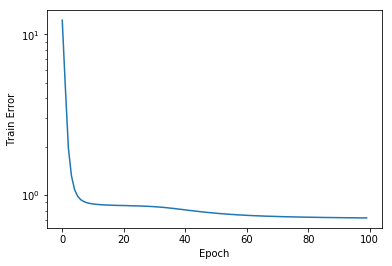

In [36]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [37]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

In [38]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.69825

In [39]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,-0.881171,0.878086,1.006004
std,0.447594,0.539514,0.409604
min,-2.437620,-0.735617,-0.249176
25%,-1.187833,0.465435,0.736540
50%,-0.898288,0.903990,1.023940
75%,-0.564250,1.302025,1.273921
max,0.684617,2.162355,2.780163


## Non Negative Matrix Factorization

In [41]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input) ## Contraining to non negative values
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = keras.layers.dot([movie_vec, user_vec],axes=1,name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [43]:
history_nonneg = model.fit([train.user_id, train.movie_id], train.rating, epochs=10, verbose=0)


In [44]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.7169

## Deep Matrix Factorization

In [61]:
n_latent_factors_user = 8
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec],axis = -1,name='Concat')
#concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
#dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
#dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
#dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

In [62]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 8)         7552        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [ ]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=250, verbose=0)


In [ ]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

## Visualization

In [52]:
## Getting the embeddings of the movies
item_embeddings = model.get_layer(name='Movie-Embedding').get_weights()[0]
user_embeddings = model.get_layer(name='User-Embedding').get_weights()[0]

In [56]:
pd.DataFrame(item_embeddings).describe()

,0,1,2,3,4,5,6,7
count,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000
mean,0.372052,0.751935,-0.740271,-0.902967,-0.954656,0.769442,0.732292,-0.748119
std,2.548606,2.118965,2.005908,2.367340,2.577334,2.097792,2.003236,2.010878
min,-10.977203,-6.010849,-7.264585,-12.047708,-13.708546,-5.076320,-4.868632,-8.990916
25%,-0.998919,-0.642476,-2.136961,-2.168168,-1.902370,-0.581727,-0.560485,-1.963420
50%,0.270652,0.454739,-0.489312,-0.432997,-0.414222,0.442465,0.494343,-0.508552
75%,1.796331,2.009000,0.607211,0.579100,0.611776,2.083043,1.937536,0.521411
max,13.660876,8.711674,5.111701,5.125308,4.957308,7.864892,8.030776,5.025041
